In [5]:
import Pkg; Pkg.activate(".")

  Activating project at `~/SAFT_ML`


In [4]:
using Revise
import Base: @kwdef

using Clapeyron
import Clapeyron: SAFTVRMieModel, @f, @newmodel, transform_params, default_locations, default_references, N_A, SingleComp, SA
import Clapeyron: a_res#, data, a_hs, a_dispchain, a_assoc
import Clapeyron: data, a_hs, a_disp, a_chain, a_assoc
import Clapeyron: SingleParam, PairParam


using Flux
using Plots
using ForwardDiff, DiffResults

In [6]:
#* Set up SAFTVRMieNN model
# Need to overload SAFTVRMie model creation to instead take in parameters from ML model
# Then, define a custom zygote function returing the VJP for the model

# All definitions of a_res only call "model.params.x" for each
# variable called x. When this is then used, it appears to 
# be used as standard 

# Standard SAFTVRMie parameters

# function SAFTVRMieNNParam(Mw, segment, sigma, lambda_a, lambda_r, epsilon, epsilon_assoc, bondvol)
#     el(x) = eltype(x.values)
#     el(x::AssocParam) = eltype(x.values.values)
#     T = mapreduce(el, promote_type, (Mw, segment, sigma, epsilon, epsilon_assoc, bondvol))
#     Mw = convert(SingleParam{T}, Mw)
#     segment = convert(SingleParam{T}, segment)
#     sigma = convert(PairParam{T}, sigma)
#     epsilon = convert(PairParam{T}, epsilon)
#     lambda_a = convert(PairParam{T}, lambda_a)
#     lambda_r = convert(PairParam{T}, lambda_r)
#     epsilon_assoc = convert(AssocParam{T}, epsilon_assoc)
#     bondvol = convert(AssocParam{T}, bondvol)
#     return SAFTVRMieNNParam{T}(Mw, segment, sigma, lambda_a, lambda_r, epsilon, epsilon_assoc, bondvol)
# end

# abstract type SAFTVRMieNNModel <: SAFTVRMieModel end

# @newmodel SAFTVRMieNN SAFTVRMieNNModel SAFTVRMieNNParam

# default_locations(::Type{SAFTVRMieNN}) = ["SAFT/SAFTVRMie", "properties/molarmass.csv"]

# Model constructor
function transform_params(::Type{SAFTVRMieNN}, params)
    sigma = params["sigma"]
    sigma.values .*= 1E-10
    sigma = sigma_LorentzBerthelot(sigma)
    epsilon = epsilon_HudsenMcCoubrey(params["epsilon"], sigma)
    lambda_a = lambda_LorentzBerthelot(params["lambda_a"])
    lambda_r = lambda_LorentzBerthelot(params["lambda_r"])
    params["sigma"] = sigma
    params["epsilon"] = epsilon
    params["lambda_a"] = lambda_a
    params["lambda_r"] = lambda_r
    return params
end

transform_params (generic function with 29 methods)

In [8]:
f(x) = SingleParam("_", ["methane"], [x])
g(x) = PairParam("_", ["methane"], [x])
h(x) = AssocParam("_", ["methane"], [x])
y = SAFTVRMieNNParam(
    Mw=f(1.0),
    segment=f(1.0),
    sigma=f(1.0),
    lambda_a=g(1.0),
    lambda_r=g(1.0),
    epsilon=g(1.0),
    epsilon_assoc=h(1.0),
    bondvol=h(1.0),
)
# x = SingleParam("MW", ["methane"], [1.0])

# f(x::SingleParam) = x.^2
# f(x) = x.^2
# f2(x) = f(x.values)
# @show f(x)
# ForwardDiff.gradient(f, x.values)

MethodError: MethodError: no method matching AssocParam(::String, ::Vector{String}, ::Vector{Float64})
Closest candidates are:
  AssocParam(::String, ::Vector{String}, !Matched::AbstractMatrix{<:AbstractMatrix{T}} where T) at ~/.julia/dev/Clapeyron/src/database/params/AssocParam.jl:81
  AssocParam(::String, ::Vector{String}, !Matched::AbstractMatrix{<:AbstractMatrix{T}} where T, !Matched::Any) at ~/.julia/dev/Clapeyron/src/database/params/AssocParam.jl:81
  AssocParam(::String, ::Vector{String}, !Matched::AbstractMatrix{<:AbstractMatrix{T}} where T, !Matched::Any, !Matched::Any) at ~/.julia/dev/Clapeyron/src/database/params/AssocParam.jl:81
  ...

In [ ]:
# function Clapeyron.SAFTVRMieNN(;
#     Mw=1.0,
#     segment=1.0,
#     sigma=1.0,
#     lambda_a=1.0,
#     lambda_r=1.0,
#     epsilon=1.0,
#     bondvol=1.0
# )
    # idealmodel=Clapeyron.BasicIdeal,

    # userlocations=String[],
    # group_userlocations=String[],
    # ideal_userlocations=String[],
    # assoc_options=Clapeyron.default_assoc_options($name),
    # verbose=false)

    # Clapeyron.build_eosmodel($name, components, idealmodel, userlocations, group_userlocations, ideal_userlocations, verbose, assoc_options)
# end


In [10]:
function flatten_tuple(t, arr=Vector{Float64}())
    for elem in t
        if elem isa Number
            push!(arr, elem)
        else
            flatten_tuple(elem, arr)
        end
    end
    return arr
end

# Define neural net
NN = Chain(
    Dense(13, 10, relu),
    Dense(10, 1),
)

# Wrap NN function for a_res
function NN_a_res(model::SAFTVRMieNN, V, T, z, _data)
    # Flatten data
    flat_data = flatten_tuple(_data)
    # input = vcat(flat_data, [V, T, z])
    append!(flat_data, [V, T])
    append!(flat_data, z)
    return NN(flat_data)[1]
end

# Define NN-enhanced a_res
function a_res(model::SAFTVRMieNN, V, T, z)
    _data = @f(data)
    NN_term = @f(NN_a_res, _data)
    println(NN_term)

    return @f(a_hs, _data) + @f(a_disp, _data) + @f(a_chain, _data) + @f(a_assoc, _data) + NN_term
end

function a_res(model, V, T)
    return a_res(model, V, T, [1.0])
end

model = SAFTVRMieNN(["methane"])
base_model = SAFTVRMie(["methane"])
ground_truth = GERG2008(["methane"])

T = 273.15

X_data = 10.0 .^ range(-5, -2, length=100)
Y_data = a_res.(ground_truth, X_data, T)

train_data = zip(X_data, Y_data)

# Train model 
loss(y, ŷ) = sum((ŷ .- y).^2)


full_model(x) = a_res(model, x, T)

opt_state = Flux.setup(Adam(), NN)

epochs = 100 
for epoch in 1:epochs
    println("Epoch $epoch: ")
    losses = Float64[]
    for (i, data) in enumerate(train_data)
        x, y = data

        val, grads = Flux.withgradient(full_model) do m 
            ŷ = m(x)
            loss(y, ŷ)
        end

        push!(losses, val)
        println("Val: $val, grads: $grads")

        Flux.update!(opt_state, NN, grads[1])
    end
end


Epoch 1: 


-8.4673684e27


MethodError: MethodError: no method matching ndims(::ChainRulesCore.Tangent{Any, NTuple{6, Float64}})
Closest candidates are:
  ndims(!Matched::AbstractChar) at char.jl:196
  ndims(!Matched::KernelAbstractions.NDIteration.StaticSize{S}) where S at ~/.julia/packages/KernelAbstractions/cWlFz/src/nditeration.jl:28
  ndims(!Matched::SpatialIndexing.Region) at ~/.julia/packages/SpatialIndexing/zc4eD/src/regions.jl:10
  ...

In [13]:
using Flux
using ForwardDiff

# Your existing functions and data setup here
# ...

# Function to flatten the model parameters into a single vector
function flatten_params(model)
    return vcat(map(p -> vec(p), Flux.params(model))...)
end

# Function to unflatten a single vector into the model parameters
function unflatten_params!(model, flat_params)
    i = 1
    for p in Flux.params(model)
        len = length(p)
        p .= reshape(flat_params[i:i+len-1], size(p))
        i += len
    end
end

# Loss function wrapper for ForwardDiff
function loss_wrapper(flat_params, model, x, y)
    unflatten_params!(model, flat_params)
    ŷ = full_model(x)
    return loss(y, ŷ)
end

# Initialize optimizer and training setup
opt_state = Flux.setup(Adam(), NN)
epochs = 100

for epoch in 1:epochs
    println("Epoch $epoch: ")
    losses = Float64[]
    
    for (i, data) in enumerate(train_data)
        x, y = data
        flat_params = flatten_params(NN)
        
        # Compute gradient using ForwardDiff
        grads = ForwardDiff.gradient(p -> loss_wrapper(p, NN, x, y), flat_params)
        
        # Unflatten gradients to update model parameters
        unflatten_params!(NN, flat_params .- 0.01 .* grads)  # Assuming learning rate of 0.01
        
        # Compute and store loss
        val = loss(full_model(x), y)
        push!(losses, val)
        println("Loss: $val")
    end
end


Epoch 1: 


MethodError: MethodError: no method matching Float32(::ForwardDiff.Dual{ForwardDiff.Tag{var"#28#29"{Float64, Float64}, Float32}, Float32, 12})
Closest candidates are:
  (::Type{T})(::Real, !Matched::RoundingMode) where T<:AbstractFloat at rounding.jl:200
  (::Type{T})(::T) where T<:Number at boot.jl:772
  (::Type{T})(!Matched::AbstractChar) where T<:Union{AbstractChar, Number} at char.jl:50
  ...

In [5]:
# Objective: Learn a NN term modifying SAFT-VR Mie EOS to match GERG-2008

# Baseline comparison
ground_truth = GERG2008(["methane"])
saft_vr_mie = SAFTVRMie(["methane"])
pc_saft = PCSAFT(["methane"])

# Create vT phase diagram
function get_saturation_line(model)
    Tc, pc, Vc = crit_pure(model)
    n = 1000
    Ts = range(0.5Tc, 0.999999Tc, length=n)

    # X shaped as n-long vector of 3-tuples
    X_crit = [pc, Vc, Vc]
    X = saturation_pressure.(model, Ts)
    f(i) = [x[i] for x in X]
    p, Vl, Vv = f(1), f(2), f(3)
    append!(p, pc)
    append!(Vl, Vc)
    append!(Vv, Vc)
    
    return p, Vl, Vv
end

get_saturation_line (generic function with 1 method)

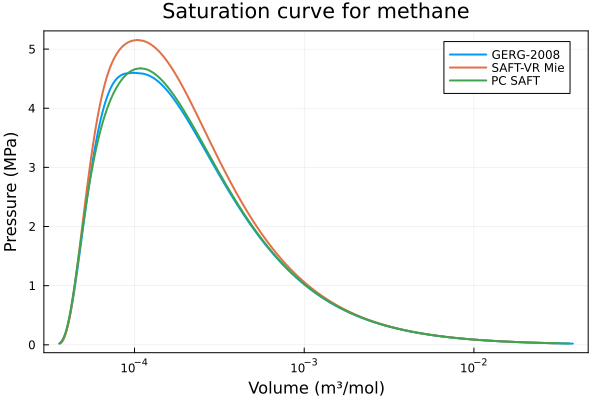

In [6]:
fig = plot(
    title="Saturation curve for methane",
    xaxis=:log,
    box=:on,
)
xlabel!("Volume (m³/mol)")
ylabel!("Pressure (MPa)")

models = [ground_truth, saft_vr_mie, pc_saft]
labels = ["GERG-2008", "SAFT-VR Mie", "PC SAFT"]

for (i, (model, label)) in enumerate(zip(models, labels))
    pc, Vl, Vv = get_saturation_line(model)
    plot!(Vl, pc/1e6, lw=2, color=i,  label=label)
    plot!(Vv, pc/1e6, lw=2, color=i, label="")
end
fig

In [7]:
# Test registering model locally 

# abstract type PCSAFTNNModel <: SAFTModel end
# @newmodel PCSAFTNN
# include("pcsaft.jl")

abstract type PCSAFTNNModel <: PCSAFTModel end 

UndefVarError: UndefVarError: PCSAFTModel not defined